In [12]:
# import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
# %matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, train_test_split

text_mining_keywords = ['cochera', 'sum', 'parrilla', 'pileta']


def vectorize_descripcion(df: pd.DataFrame):
    descripcion = df['descripcion']
    descripcion[descripcion.isna()] = ''

    
    # entrenamos el modelo para buscar las keywords
    vectorizer = CountVectorizer(binary=True)  
    vectorizer.fit(text_mining_keywords)

    # hot encoding de los resultados
    df_countvectorizer = vectorizer.transform(descripcion)

    desc = pd.DataFrame(df_countvectorizer.toarray())
    desc.columns = text_mining_keywords
    
    df.drop(['descripcion'], axis=1, inplace=True)
    return(pd.concat([df, desc], axis=1))
    

def preprocessing(df: pd.DataFrame):
    # guardar los id
    ids = df['id']

    # eliminar columnas innecesarias del modelo
    df.drop(['id', 'pub_inicio', 'pub_fin', 'pub_creada', 'subbarrio', 'titulo'],axis=1, inplace=True)

    df = vectorize_descripcion(df)

    return ids, df


def split_data(df: pd.DataFrame, test_size = 0.05):
    y = df['precio']
    X = df.drop(['precio'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=5)
    return X_train, X_test, y_train, y_test


## Preprocesamiento de los features: imputación, estandarización, one-hot encoding
def make_transformer_pipeline():
    numeric_features = ['lat', 'lon', 'habitaciones', 'dormitorios', 'banios',
       'sup_total', 'sup_cubierta', 'cochera', 'sum', 'parrilla',
       'pileta']
    numeric_transformer = make_pipeline( 
        SimpleImputer(missing_values = np.nan, strategy='mean'),
        StandardScaler(),
    )

    categorical_features = ['barrio']
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        #SimpleImputer(strategy="most_frequent"),
        #KNNImputer(n_neighbors=3, weights="uniform"),     # KNNImputer tarda una eternidad...
        OneHotEncoder(handle_unknown='ignore')
    )

    return make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features)
    )    

## Crear modelo RandomForestRegressor
def create_train_rgr_model(df: pd.DataFrame):
    transformer = make_transformer_pipeline()
    rfr = RandomForestRegressor(n_estimators=100, random_state = 5)

    pipeline = make_pipeline(transformer, rfr)
    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    return model

## Crear modelo SVR
def create_train_svr_model(df: pd.DataFrame):
    transformer = make_transformer_pipeline()
    
    #svr = SVR()
    # pipeline = make_pipeline(transformer, svr)
    # model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
    # return model    

    model_pipe = Pipeline([
        ('preprocessing', transformer),
        ('model', TransformedTargetRegressor(SVR(cache_size=1000), transformer=StandardScaler()))
    ])
    return model_pipe

## Crear modelo LinearRegression
def create_train_lr_model(df: pd.DataFrame):
    transformer = make_transformer_pipeline()
    lr = LinearRegression()

    pipeline = make_pipeline(transformer, lr)
    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    return model    

def plot_test_predictions(y_test, y_pred):
    # graficar predicciones contra datos actuales
    plt.figure(figsize = (18,10))
    plot_k = sns.scatterplot(y_test, y_pred)
    plot_k.set(xlabel='Precio test', ylabel='Precio predicción')
    # graficar la identidad
    x_plot = np.linspace(0,np.max(y_test),1000)
    y_plot = x_plot
    plt.plot(x_plot, y_plot, color='r')



In [13]:
df_train = pd.read_excel('https://github.com/arielfaur/prediccion-precio-propiedades-fmap-2020/raw/master/propiedades_entrenamiento.xlsx')
df_train.head()

,id,pub_inicio,pub_fin,pub_creada,lat,lon,barrio,subbarrio,habitaciones,dormitorios,banios,sup_total,sup_cubierta,titulo,descripcion,precio
0,1,2019-11-20,9999-12-31,2019-11-20,-34.606891,-58.409890,Almagro,NaN,3.0,NaN,2.0,108.0,108.0,PISO EN VENTA 3 AMB C/ ESC. Y DEP. EN ALMAGRO,Piso en Venta 3 ambientes c/ Escritorio y Depe...,150000
1,3,2019-11-19,2020-02-22,2019-11-19,-34.604912,-58.417065,Almagro,NaN,3.0,1.0,2.0,72.0,63.0,Venta Departamento en Almagro Capital Federal ...,"Departamento en Venta, 3 AMBIENTES + COCHERA E...",144000
2,4,2019-05-21,2019-07-03,2019-05-21,-34.600886,-58.431204,Villa Crespo,NaN,3.0,2.0,1.0,57.0,57.0,DEPARTAMENTO EN VENTA,Xintel (GOP-GOP-8943) Venta de Departamento 3 ...,145000
3,5,2019-05-21,2020-05-22,2019-05-21,-34.628760,-58.453224,Flores,NaN,4.0,3.0,3.0,128.0,117.0,DEPARTAMENTO EN VENTA,Xintel (AGU-AGU-3167) Hermoso 3 ambientes al ...,585000
4,6,2019-07-15,2020-02-13,2019-07-15,-34.572144,-58.480173,Villa Urquiza,NaN,3.0,NaN,2.0,NaN,60.0,Departamento en Venta ubicado en Villa Urquiza R,"Venta - Departamento - Argentina, Buenos Aires...",237000


In [14]:
ids, df_train = preprocessing(df_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
X_train, X_test, y_train, y_test = split_data(df_train)

In [ ]:
# Entrenar modelo SVR con búsqueda de hiperparámetros
tuned_parameters = [{'model__regressor__kernel': ['rbf'], 
                    'model__regressor__gamma': np.logspace(-3, 3, 3),
                    'model__regressor__C': np.logspace(-3, 3, 4)},
                    # {'model__regressor__kernel': ['linear'], 
                    #  'model__regressor__C': [1, 10, 100, 1000]}
                    ]
model_svr = create_train_svr_model(df_train)

model = GridSearchCV(model_svr, tuned_parameters, n_jobs=2, scoring=('r2', 'neg_root_mean_squared_error'), refit='neg_root_mean_squared_error')
model.fit(X_train, y_train)

In [ ]:
Noprint("Mejores parámetros encontrados:")
print()
print(model.best_params_)
print()
print("Grid scores:")
print(model.cv_results_)


In [ ]:
model = create_train_rgr_model(df_train)
scores = cross_validate(model, X_train, y_train, cv=5, scoring=('r2', 'neg_root_mean_squared_error'))

print(scores['test_neg_root_mean_squared_error'])
print(scores['test_r2'])



[-101849.97517102 -101586.23252035 -126161.02848328 -130073.85777698
 -144675.90241489]
[0.85364592 0.87617876 0.81735818 0.80018301 0.73972298]


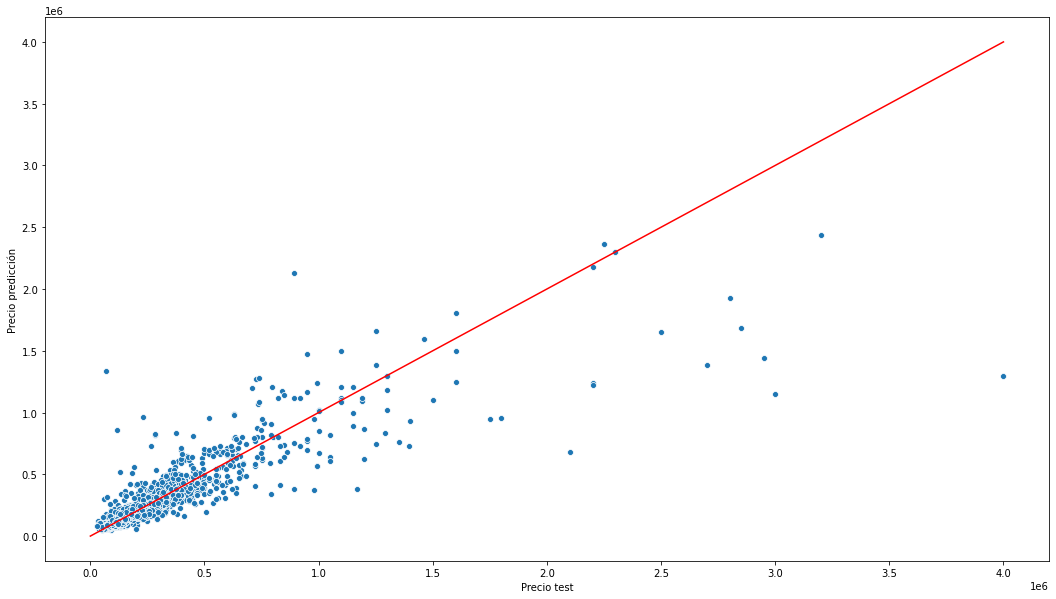

In [ ]:
y_pred = cross_val_predict(model, X_test, y_test, cv=5)
plot_test_predictions(y_test, y_pred)

In [ ]:
df_test = pd.read_excel('https://github.com/arielfaur/prediccion-precio-propiedades-fmap-2020/raw/master/propiedades_prueba.xlsx')
df_test.head()

,id,pub_inicio,pub_fin,pub_creada,lat,lon,barrio,subbarrio,habitaciones,dormitorios,banios,sup_total,sup_cubierta,titulo,descripcion,precio
0,2,2019-10-23,9999-12-31,2019-10-23,-34.586330,-58.508957,Villa Devoto,NaN,1.0,NaN,NaN,45,37,Ladines 3200 pb - U$D 124.000 - Departamento ...,Impecable 2 ambientes con patio cubierto con t...,NaN
1,34,2019-05-07,2019-06-23,2019-05-07,-34.581699,-58.433547,Palermo,Palermo Hollywood,1.0,1.0,1.0,53,40,VENTA MONOAMBIENTE ESPECTACULAR EN COLEGIALES,Monoambiente impecable divisible a dos ambient...,NaN
2,54,2019-10-13,2019-12-23,2019-10-13,-34.628187,-58.429586,Caballito,NaN,2.0,1.0,1.0,42,38,2 ambientes divisibles a estrenar en Palmera C...,Palmera Caballito: Torre con amenities de gran...,NaN
3,101,2019-08-25,2019-09-14,2019-08-25,-34.593716,-58.440695,Palermo,NaN,2.0,1.0,1.0,62,38,Depto 2 amb c/terraza prpia Palermo Queens out...,Corredor Responsable: Ariel Champanier - CUCIC...,NaN
4,103,2019-10-23,2019-11-09,2019-10-23,-34.591336,-58.447218,Villa Crespo,NaN,2.0,1.0,1.0,44,40,Departamento de dos ambientes con cochera en v...,Departamento de 2 ambientes con cochera ubicad...,NaN


In [ ]:
ids, df_test = preprocessing(df_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
model.fit(X_train, y_train)


TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('columntransformer',
                                                      ColumnTransformer(n_jobs=None,
                                                                        remainder='drop',
                                                                        sparse_threshold=0.3,
                                                                        transformer_weights=None,
                                                                        transformers=[('pipeline-1',
                                                                                       Pipeline(memory=None,
                                                                                                steps=[('simpleimputer',
                                                                                           

In [ ]:
predicted = model.predict(df_test)
data = pd.DataFrame(data={'id' : ids.values, 'precio': np.round(predicted).astype(int) })

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [ ]:
data


,id,precio
0,2,106921
1,34,222652
2,54,130563
3,101,133604
4,103,119023
...,...,...
2495,53190,126725
2496,53221,281880
2497,53233,100948
2498,53243,130963


In [ ]:
from google.colab import files
data.to_csv('propiedades_prediccion.csv', index=False)
files.download('propiedades_prediccion.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>